<a href="https://colab.research.google.com/github/SzymonNowakowski/Workshops/blob/2023_2/Day_3/10_understanding%20FNO%20basic%20components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper

The workshop today will be based on the following paper:
Li, Zongyi, Nikola Kovachki, Kamyar Azizzadenesheli, Burigede Liu, Kaushik Bhattacharya, Andrew Stuart, and Anima Anandkumar. 2020. “Fourier Neural Operator for Parametric Partial Differential Equations.” arXiv [cs.LG]. arXiv. http://arxiv.org/abs/2010.08895.

![Title page](https://i.imgur.com/7L3LDnD.png)



        

# Darcy Flow

The model problem that is considered in the FNO paper and we will consider today, too, is the Darcy Flow problem.

Darcy Flow problem models **flow pressure $u(x)$** in a porous material. It is a second order PDE given by the following formulation:

$- \nabla \cdot \left( k \left( x \right) \nabla u \left( x \right) \right) = f \left( x \right), \;\;\;\; x \in D \subset \mathbb{R}^2$

with the boundary condition

$ u(x) = 0, x \in \partial D$.

 - $k(x) $ is a permeteablity field,
 - $f(x)$ is a forcing function. $f(x) = 1$ in the paper experiments and in our examples,
 - $D$ is the problem domain. $D = (0,1)^2$ in our experiments.

Recall, that with PINN we could solve a one instance problem by learning a neural network $u(x)$ for a given instance of $k(x)$ by adding an explicit loss related to the PDE.

In contrast, FNO will learn a mapping between a permeteablity field and the flow pressure field. More formally, let $k \in K, u \in U$ and $K$ and $U$ will be function spaces with sufficient regularity. We will construct a mapping

$FNO: K \rightarrow U$

To formalize the notion of this mapping expected prediction error (say in terms of the mean square error), we would also need a probability distribution $P_K$ defined on $K$. This probability distribution would control input values $k \in K$ and allow us to express expected MSE of predicted $\hat u(x) = FNO(k) (x)$ vs the ground truth $u(k)(x)$ with respect to $P_K$.

However, in order to estimate this error, it suffices to sample the test set instances from the same distribution $P_K$.

We will use the train and test set provided by the FNO paper authors, so we will not need to bother with $P_K$ from now on. I felt compelled to give you that detail explicitly, as it is important.

The below figure is taken from [the NVIDIA tutorial on FNOs](https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/neural_operators/darcy_fno.html) which I strongly recommend as complementary to what I will cover today.
![FNO diagram](https://docscontent.nvidia.com/dims4/default/390f7b0/2147483647/strip/true/crop/1517x257+0+0/resize/1440x244!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000187-bf1b-d3c6-a7f7-ff7f4e8b0000%2Fdeeplearning%2Fmodulus%2Fmodulus-v2209%2F_images%2Ffno_darcy.png)




# FNO Architecture

We will be working with the following network architecture (this figure comes from the FNOpaper):

![FNO architecture](https://i.imgur.com/muYkubI.png)

## Input and output

In this Workshop, the FNO will take as input a function defined on a rectangle $R = [a, b] ^ 2 \subset \mathbb{R}^2, f: R → \mathbb{R}$.

The output of the FNO will be another function $g: R → \mathbb{R}$.

During the workshop we will keep track of orders and dimensions of the tensor as it progresses from being an input tensor towards the output.

## Input and output format (discretization)

The FNO is **unable** to take as input a function in a mathematical sense, i.e. as a smooth and regular construct *acting* on numbers in $R$ and returning values in $\mathbb{R}$.

Instead, the input and output will be provided in a discretized way, with function values specified in the grid points, with this grid coordinates explicitly passed as well:





In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
input_data = torch.Tensor([[[1.0000, 0.0000, 0.0000],         [1.0000, 0.0000, 0.0625],         [1.0000, 0.0000, 0.1250],         [0.0000, 0.0000, 0.1875],         [0.0000, 0.0000, 0.2500],         [0.0000, 0.0000, 0.3125],         [0.0000, 0.0000, 0.3750],         [0.0000, 0.0000, 0.4375],         [0.0000, 0.0000, 0.5000],         [1.0000, 0.0000, 0.5625],         [1.0000, 0.0000, 0.6250],         [1.0000, 0.0000, 0.6875],         [1.0000, 0.0000, 0.7500],         [1.0000, 0.0000, 0.8125],         [1.0000, 0.0000, 0.8750],         [0.0000, 0.0000, 0.9375]],        [[1.0000, 0.0625, 0.0000],         [1.0000, 0.0625, 0.0625],         [1.0000, 0.0625, 0.1250],         [0.0000, 0.0625, 0.1875],         [0.0000, 0.0625, 0.2500],         [0.0000, 0.0625, 0.3125],         [0.0000, 0.0625, 0.3750],         [0.0000, 0.0625, 0.4375],         [0.0000, 0.0625, 0.5000],         [1.0000, 0.0625, 0.5625],         [1.0000, 0.0625, 0.6250],         [1.0000, 0.0625, 0.6875],         [1.0000, 0.0625, 0.7500],         [1.0000, 0.0625, 0.8125],         [0.0000, 0.0625, 0.8750],         [0.0000, 0.0625, 0.9375]],        [[1.0000, 0.1250, 0.0000],         [1.0000, 0.1250, 0.0625],         [1.0000, 0.1250, 0.1250],         [0.0000, 0.1250, 0.1875],         [0.0000, 0.1250, 0.2500],         [0.0000, 0.1250, 0.3125],         [0.0000, 0.1250, 0.3750],         [0.0000, 0.1250, 0.4375],         [0.0000, 0.1250, 0.5000],         [1.0000, 0.1250, 0.5625],         [1.0000, 0.1250, 0.6250],         [1.0000, 0.1250, 0.6875],         [1.0000, 0.1250, 0.7500],         [1.0000, 0.1250, 0.8125],         [1.0000, 0.1250, 0.8750],         [0.0000, 0.1250, 0.9375]],        [[1.0000, 0.1875, 0.0000],         [1.0000, 0.1875, 0.0625],         [1.0000, 0.1875, 0.1250],         [0.0000, 0.1875, 0.1875],         [0.0000, 0.1875, 0.2500],         [0.0000, 0.1875, 0.3125],         [0.0000, 0.1875, 0.3750],         [0.0000, 0.1875, 0.4375],         [0.0000, 0.1875, 0.5000],         [1.0000, 0.1875, 0.5625],         [1.0000, 0.1875, 0.6250],         [1.0000, 0.1875, 0.6875],         [1.0000, 0.1875, 0.7500],         [1.0000, 0.1875, 0.8125],         [1.0000, 0.1875, 0.8750],         [1.0000, 0.1875, 0.9375]],        [[1.0000, 0.2500, 0.0000],         [1.0000, 0.2500, 0.0625],         [1.0000, 0.2500, 0.1250],         [0.0000, 0.2500, 0.1875],         [0.0000, 0.2500, 0.2500],         [0.0000, 0.2500, 0.3125],         [0.0000, 0.2500, 0.3750],         [0.0000, 0.2500, 0.4375],         [0.0000, 0.2500, 0.5000],         [1.0000, 0.2500, 0.5625],         [1.0000, 0.2500, 0.6250],         [1.0000, 0.2500, 0.6875],         [1.0000, 0.2500, 0.7500],         [1.0000, 0.2500, 0.8125],         [1.0000, 0.2500, 0.8750],         [0.0000, 0.2500, 0.9375]],        [[1.0000, 0.3125, 0.0000],         [1.0000, 0.3125, 0.0625],         [1.0000, 0.3125, 0.1250],         [0.0000, 0.3125, 0.1875],         [0.0000, 0.3125, 0.2500],         [0.0000, 0.3125, 0.3125],         [0.0000, 0.3125, 0.3750],         [0.0000, 0.3125, 0.4375],         [1.0000, 0.3125, 0.5000],         [1.0000, 0.3125, 0.5625],         [1.0000, 0.3125, 0.6250],         [1.0000, 0.3125, 0.6875],         [1.0000, 0.3125, 0.7500],         [1.0000, 0.3125, 0.8125],         [1.0000, 0.3125, 0.8750],         [0.0000, 0.3125, 0.9375]],        [[1.0000, 0.3750, 0.0000],         [1.0000, 0.3750, 0.0625],         [0.0000, 0.3750, 0.1250],         [0.0000, 0.3750, 0.1875],         [0.0000, 0.3750, 0.2500],         [1.0000, 0.3750, 0.3125],         [1.0000, 0.3750, 0.3750],         [1.0000, 0.3750, 0.4375],         [1.0000, 0.3750, 0.5000],         [1.0000, 0.3750, 0.5625],         [1.0000, 0.3750, 0.6250],         [1.0000, 0.3750, 0.6875],         [1.0000, 0.3750, 0.7500],         [1.0000, 0.3750, 0.8125],         [1.0000, 0.3750, 0.8750],         [0.0000, 0.3750, 0.9375]],        [[1.0000, 0.4375, 0.0000],         [1.0000, 0.4375, 0.0625],         [0.0000, 0.4375, 0.1250],         [0.0000, 0.4375, 0.1875],         [1.0000, 0.4375, 0.2500],         [1.0000, 0.4375, 0.3125],         [1.0000, 0.4375, 0.3750],         [1.0000, 0.4375, 0.4375],         [1.0000, 0.4375, 0.5000],         [1.0000, 0.4375, 0.5625],         [1.0000, 0.4375, 0.6250],         [1.0000, 0.4375, 0.6875],         [1.0000, 0.4375, 0.7500],         [1.0000, 0.4375, 0.8125],         [1.0000, 0.4375, 0.8750],         [0.0000, 0.4375, 0.9375]],        [[0.0000, 0.5000, 0.0000],         [0.0000, 0.5000, 0.0625],         [1.0000, 0.5000, 0.1250],         [1.0000, 0.5000, 0.1875],         [1.0000, 0.5000, 0.2500],         [1.0000, 0.5000, 0.3125],         [1.0000, 0.5000, 0.3750],         [1.0000, 0.5000, 0.4375],         [1.0000, 0.5000, 0.5000],         [1.0000, 0.5000, 0.5625],         [1.0000, 0.5000, 0.6250],         [1.0000, 0.5000, 0.6875],         [1.0000, 0.5000, 0.7500],         [1.0000, 0.5000, 0.8125],         [1.0000, 0.5000, 0.8750],         [0.0000, 0.5000, 0.9375]],        [[0.0000, 0.5625, 0.0000],         [0.0000, 0.5625, 0.0625],         [1.0000, 0.5625, 0.1250],         [1.0000, 0.5625, 0.1875],         [1.0000, 0.5625, 0.2500],         [1.0000, 0.5625, 0.3125],         [1.0000, 0.5625, 0.3750],         [1.0000, 0.5625, 0.4375],         [1.0000, 0.5625, 0.5000],         [1.0000, 0.5625, 0.5625],         [1.0000, 0.5625, 0.6250],         [1.0000, 0.5625, 0.6875],         [1.0000, 0.5625, 0.7500],         [1.0000, 0.5625, 0.8125],         [1.0000, 0.5625, 0.8750],         [0.0000, 0.5625, 0.9375]],        [[0.0000, 0.6250, 0.0000],         [0.0000, 0.6250, 0.0625],         [0.0000, 0.6250, 0.1250],         [1.0000, 0.6250, 0.1875],         [1.0000, 0.6250, 0.2500],         [1.0000, 0.6250, 0.3125],         [1.0000, 0.6250, 0.3750],         [1.0000, 0.6250, 0.4375],         [1.0000, 0.6250, 0.5000],         [1.0000, 0.6250, 0.5625],         [1.0000, 0.6250, 0.6250],         [1.0000, 0.6250, 0.6875],         [1.0000, 0.6250, 0.7500],         [1.0000, 0.6250, 0.8125],         [0.0000, 0.6250, 0.8750],         [0.0000, 0.6250, 0.9375]],        [[0.0000, 0.6875, 0.0000],         [0.0000, 0.6875, 0.0625],         [0.0000, 0.6875, 0.1250],         [0.0000, 0.6875, 0.1875],         [1.0000, 0.6875, 0.2500],         [1.0000, 0.6875, 0.3125],         [1.0000, 0.6875, 0.3750],         [1.0000, 0.6875, 0.4375],         [1.0000, 0.6875, 0.5000],         [1.0000, 0.6875, 0.5625],         [1.0000, 0.6875, 0.6250],         [1.0000, 0.6875, 0.6875],         [1.0000, 0.6875, 0.7500],         [0.0000, 0.6875, 0.8125],         [0.0000, 0.6875, 0.8750],         [0.0000, 0.6875, 0.9375]],        [[0.0000, 0.7500, 0.0000],         [0.0000, 0.7500, 0.0625],         [0.0000, 0.7500, 0.1250],         [0.0000, 0.7500, 0.1875],         [0.0000, 0.7500, 0.2500],         [0.0000, 0.7500, 0.3125],         [0.0000, 0.7500, 0.3750],         [1.0000, 0.7500, 0.4375],         [1.0000, 0.7500, 0.5000],         [1.0000, 0.7500, 0.5625],         [1.0000, 0.7500, 0.6250],         [1.0000, 0.7500, 0.6875],         [1.0000, 0.7500, 0.7500],         [0.0000, 0.7500, 0.8125],         [0.0000, 0.7500, 0.8750],         [0.0000, 0.7500, 0.9375]],        [[0.0000, 0.8125, 0.0000],         [0.0000, 0.8125, 0.0625],         [0.0000, 0.8125, 0.1250],         [0.0000, 0.8125, 0.1875],         [0.0000, 0.8125, 0.2500],         [0.0000, 0.8125, 0.3125],         [0.0000, 0.8125, 0.3750],         [0.0000, 0.8125, 0.4375],         [0.0000, 0.8125, 0.5000],         [0.0000, 0.8125, 0.5625],         [0.0000, 0.8125, 0.6250],         [0.0000, 0.8125, 0.6875],         [0.0000, 0.8125, 0.7500],         [0.0000, 0.8125, 0.8125],         [0.0000, 0.8125, 0.8750],         [0.0000, 0.8125, 0.9375]],        [[0.0000, 0.8750, 0.0000],         [0.0000, 0.8750, 0.0625],         [0.0000, 0.8750, 0.1250],         [0.0000, 0.8750, 0.1875],         [0.0000, 0.8750, 0.2500],         [0.0000, 0.8750, 0.3125],         [0.0000, 0.8750, 0.3750],         [0.0000, 0.8750, 0.4375],         [0.0000, 0.8750, 0.5000],         [0.0000, 0.8750, 0.5625],         [0.0000, 0.8750, 0.6250],         [0.0000, 0.8750, 0.6875],         [0.0000, 0.8750, 0.7500],         [0.0000, 0.8750, 0.8125],         [0.0000, 0.8750, 0.8750],         [0.0000, 0.8750, 0.9375]],        [[0.0000, 0.9375, 0.0000],         [0.0000, 0.9375, 0.0625],         [0.0000, 0.9375, 0.1250],         [0.0000, 0.9375, 0.1875],         [0.0000, 0.9375, 0.2500],         [0.0000, 0.9375, 0.3125],         [0.0000, 0.9375, 0.3750],         [0.0000, 0.9375, 0.4375],         [0.0000, 0.9375, 0.5000],         [0.0000, 0.9375, 0.5625],         [0.0000, 0.9375, 0.6250],         [0.0000, 0.9375, 0.6875],         [0.0000, 0.9375, 0.7500],         [0.0000, 0.9375, 0.8125],         [0.0000, 0.9375, 0.8750],         [0.0000, 0.9375, 0.9375]]])

In [ ]:
# @title
input_data = torch.Tensor([[[1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0625],
         [1.0000, 0.0000, 0.1250],
         [0.0000, 0.0000, 0.1875],
         [0.0000, 0.0000, 0.2500],
         [0.0000, 0.0000, 0.3125],
         [0.0000, 0.0000, 0.3750],
         [0.0000, 0.0000, 0.4375],
         [0.0000, 0.0000, 0.5000],
         [1.0000, 0.0000, 0.5625],
         [1.0000, 0.0000, 0.6250],
         [1.0000, 0.0000, 0.6875],
         [1.0000, 0.0000, 0.7500],
         [1.0000, 0.0000, 0.8125],
         [1.0000, 0.0000, 0.8750],
         [0.0000, 0.0000, 0.9375]],

        [[1.0000, 0.0625, 0.0000],
         [1.0000, 0.0625, 0.0625],
         [1.0000, 0.0625, 0.1250],
         [0.0000, 0.0625, 0.1875],
         [0.0000, 0.0625, 0.2500],
         [0.0000, 0.0625, 0.3125],
         [0.0000, 0.0625, 0.3750],
         [0.0000, 0.0625, 0.4375],
         [0.0000, 0.0625, 0.5000],
         [1.0000, 0.0625, 0.5625],
         [1.0000, 0.0625, 0.6250],
         [1.0000, 0.0625, 0.6875],
         [1.0000, 0.0625, 0.7500],
         [1.0000, 0.0625, 0.8125],
         [0.0000, 0.0625, 0.8750],
         [0.0000, 0.0625, 0.9375]],

        [[1.0000, 0.1250, 0.0000],
         [1.0000, 0.1250, 0.0625],
         [1.0000, 0.1250, 0.1250],
         [0.0000, 0.1250, 0.1875],
         [0.0000, 0.1250, 0.2500],
         [0.0000, 0.1250, 0.3125],
         [0.0000, 0.1250, 0.3750],
         [0.0000, 0.1250, 0.4375],
         [0.0000, 0.1250, 0.5000],
         [1.0000, 0.1250, 0.5625],
         [1.0000, 0.1250, 0.6250],
         [1.0000, 0.1250, 0.6875],
         [1.0000, 0.1250, 0.7500],
         [1.0000, 0.1250, 0.8125],
         [1.0000, 0.1250, 0.8750],
         [0.0000, 0.1250, 0.9375]],

        [[1.0000, 0.1875, 0.0000],
         [1.0000, 0.1875, 0.0625],
         [1.0000, 0.1875, 0.1250],
         [0.0000, 0.1875, 0.1875],
         [0.0000, 0.1875, 0.2500],
         [0.0000, 0.1875, 0.3125],
         [0.0000, 0.1875, 0.3750],
         [0.0000, 0.1875, 0.4375],
         [0.0000, 0.1875, 0.5000],
         [1.0000, 0.1875, 0.5625],
         [1.0000, 0.1875, 0.6250],
         [1.0000, 0.1875, 0.6875],
         [1.0000, 0.1875, 0.7500],
         [1.0000, 0.1875, 0.8125],
         [1.0000, 0.1875, 0.8750],
         [1.0000, 0.1875, 0.9375]],

        [[1.0000, 0.2500, 0.0000],
         [1.0000, 0.2500, 0.0625],
         [1.0000, 0.2500, 0.1250],
         [0.0000, 0.2500, 0.1875],
         [0.0000, 0.2500, 0.2500],
         [0.0000, 0.2500, 0.3125],
         [0.0000, 0.2500, 0.3750],
         [0.0000, 0.2500, 0.4375],
         [0.0000, 0.2500, 0.5000],
         [1.0000, 0.2500, 0.5625],
         [1.0000, 0.2500, 0.6250],
         [1.0000, 0.2500, 0.6875],
         [1.0000, 0.2500, 0.7500],
         [1.0000, 0.2500, 0.8125],
         [1.0000, 0.2500, 0.8750],
         [0.0000, 0.2500, 0.9375]],

        [[1.0000, 0.3125, 0.0000],
         [1.0000, 0.3125, 0.0625],
         [1.0000, 0.3125, 0.1250],
         [0.0000, 0.3125, 0.1875],
         [0.0000, 0.3125, 0.2500],
         [0.0000, 0.3125, 0.3125],
         [0.0000, 0.3125, 0.3750],
         [0.0000, 0.3125, 0.4375],
         [1.0000, 0.3125, 0.5000],
         [1.0000, 0.3125, 0.5625],
         [1.0000, 0.3125, 0.6250],
         [1.0000, 0.3125, 0.6875],
         [1.0000, 0.3125, 0.7500],
         [1.0000, 0.3125, 0.8125],
         [1.0000, 0.3125, 0.8750],
         [0.0000, 0.3125, 0.9375]],

        [[1.0000, 0.3750, 0.0000],
         [1.0000, 0.3750, 0.0625],
         [0.0000, 0.3750, 0.1250],
         [0.0000, 0.3750, 0.1875],
         [0.0000, 0.3750, 0.2500],
         [1.0000, 0.3750, 0.3125],
         [1.0000, 0.3750, 0.3750],
         [1.0000, 0.3750, 0.4375],
         [1.0000, 0.3750, 0.5000],
         [1.0000, 0.3750, 0.5625],
         [1.0000, 0.3750, 0.6250],
         [1.0000, 0.3750, 0.6875],
         [1.0000, 0.3750, 0.7500],
         [1.0000, 0.3750, 0.8125],
         [1.0000, 0.3750, 0.8750],
         [0.0000, 0.3750, 0.9375]],

        [[1.0000, 0.4375, 0.0000],
         [1.0000, 0.4375, 0.0625],
         [0.0000, 0.4375, 0.1250],
         [0.0000, 0.4375, 0.1875],
         [1.0000, 0.4375, 0.2500],
         [1.0000, 0.4375, 0.3125],
         [1.0000, 0.4375, 0.3750],
         [1.0000, 0.4375, 0.4375],
         [1.0000, 0.4375, 0.5000],
         [1.0000, 0.4375, 0.5625],
         [1.0000, 0.4375, 0.6250],
         [1.0000, 0.4375, 0.6875],
         [1.0000, 0.4375, 0.7500],
         [1.0000, 0.4375, 0.8125],
         [1.0000, 0.4375, 0.8750],
         [0.0000, 0.4375, 0.9375]],

        [[0.0000, 0.5000, 0.0000],
         [0.0000, 0.5000, 0.0625],
         [1.0000, 0.5000, 0.1250],
         [1.0000, 0.5000, 0.1875],
         [1.0000, 0.5000, 0.2500],
         [1.0000, 0.5000, 0.3125],
         [1.0000, 0.5000, 0.3750],
         [1.0000, 0.5000, 0.4375],
         [1.0000, 0.5000, 0.5000],
         [1.0000, 0.5000, 0.5625],
         [1.0000, 0.5000, 0.6250],
         [1.0000, 0.5000, 0.6875],
         [1.0000, 0.5000, 0.7500],
         [1.0000, 0.5000, 0.8125],
         [1.0000, 0.5000, 0.8750],
         [0.0000, 0.5000, 0.9375]],

        [[0.0000, 0.5625, 0.0000],
         [0.0000, 0.5625, 0.0625],
         [1.0000, 0.5625, 0.1250],
         [1.0000, 0.5625, 0.1875],
         [1.0000, 0.5625, 0.2500],
         [1.0000, 0.5625, 0.3125],
         [1.0000, 0.5625, 0.3750],
         [1.0000, 0.5625, 0.4375],
         [1.0000, 0.5625, 0.5000],
         [1.0000, 0.5625, 0.5625],
         [1.0000, 0.5625, 0.6250],
         [1.0000, 0.5625, 0.6875],
         [1.0000, 0.5625, 0.7500],
         [1.0000, 0.5625, 0.8125],
         [1.0000, 0.5625, 0.8750],
         [0.0000, 0.5625, 0.9375]],

        [[0.0000, 0.6250, 0.0000],
         [0.0000, 0.6250, 0.0625],
         [0.0000, 0.6250, 0.1250],
         [1.0000, 0.6250, 0.1875],
         [1.0000, 0.6250, 0.2500],
         [1.0000, 0.6250, 0.3125],
         [1.0000, 0.6250, 0.3750],
         [1.0000, 0.6250, 0.4375],
         [1.0000, 0.6250, 0.5000],
         [1.0000, 0.6250, 0.5625],
         [1.0000, 0.6250, 0.6250],
         [1.0000, 0.6250, 0.6875],
         [1.0000, 0.6250, 0.7500],
         [1.0000, 0.6250, 0.8125],
         [0.0000, 0.6250, 0.8750],
         [0.0000, 0.6250, 0.9375]],

        [[0.0000, 0.6875, 0.0000],
         [0.0000, 0.6875, 0.0625],
         [0.0000, 0.6875, 0.1250],
         [0.0000, 0.6875, 0.1875],
         [1.0000, 0.6875, 0.2500],
         [1.0000, 0.6875, 0.3125],
         [1.0000, 0.6875, 0.3750],
         [1.0000, 0.6875, 0.4375],
         [1.0000, 0.6875, 0.5000],
         [1.0000, 0.6875, 0.5625],
         [1.0000, 0.6875, 0.6250],
         [1.0000, 0.6875, 0.6875],
         [1.0000, 0.6875, 0.7500],
         [0.0000, 0.6875, 0.8125],
         [0.0000, 0.6875, 0.8750],
         [0.0000, 0.6875, 0.9375]],

        [[0.0000, 0.7500, 0.0000],
         [0.0000, 0.7500, 0.0625],
         [0.0000, 0.7500, 0.1250],
         [0.0000, 0.7500, 0.1875],
         [0.0000, 0.7500, 0.2500],
         [0.0000, 0.7500, 0.3125],
         [0.0000, 0.7500, 0.3750],
         [1.0000, 0.7500, 0.4375],
         [1.0000, 0.7500, 0.5000],
         [1.0000, 0.7500, 0.5625],
         [1.0000, 0.7500, 0.6250],
         [1.0000, 0.7500, 0.6875],
         [1.0000, 0.7500, 0.7500],
         [0.0000, 0.7500, 0.8125],
         [0.0000, 0.7500, 0.8750],
         [0.0000, 0.7500, 0.9375]],

        [[0.0000, 0.8125, 0.0000],
         [0.0000, 0.8125, 0.0625],
         [0.0000, 0.8125, 0.1250],
         [0.0000, 0.8125, 0.1875],
         [0.0000, 0.8125, 0.2500],
         [0.0000, 0.8125, 0.3125],
         [0.0000, 0.8125, 0.3750],
         [0.0000, 0.8125, 0.4375],
         [0.0000, 0.8125, 0.5000],
         [0.0000, 0.8125, 0.5625],
         [0.0000, 0.8125, 0.6250],
         [0.0000, 0.8125, 0.6875],
         [0.0000, 0.8125, 0.7500],
         [0.0000, 0.8125, 0.8125],
         [0.0000, 0.8125, 0.8750],
         [0.0000, 0.8125, 0.9375]],

        [[0.0000, 0.8750, 0.0000],
         [0.0000, 0.8750, 0.0625],
         [0.0000, 0.8750, 0.1250],
         [0.0000, 0.8750, 0.1875],
         [0.0000, 0.8750, 0.2500],
         [0.0000, 0.8750, 0.3125],
         [0.0000, 0.8750, 0.3750],
         [0.0000, 0.8750, 0.4375],
         [0.0000, 0.8750, 0.5000],
         [0.0000, 0.8750, 0.5625],
         [0.0000, 0.8750, 0.6250],
         [0.0000, 0.8750, 0.6875],
         [0.0000, 0.8750, 0.7500],
         [0.0000, 0.8750, 0.8125],
         [0.0000, 0.8750, 0.8750],
         [0.0000, 0.8750, 0.9375]],

        [[0.0000, 0.9375, 0.0000],
         [0.0000, 0.9375, 0.0625],
         [0.0000, 0.9375, 0.1250],
         [0.0000, 0.9375, 0.1875],
         [0.0000, 0.9375, 0.2500],
         [0.0000, 0.9375, 0.3125],
         [0.0000, 0.9375, 0.3750],
         [0.0000, 0.9375, 0.4375],
         [0.0000, 0.9375, 0.5000],
         [0.0000, 0.9375, 0.5625],
         [0.0000, 0.9375, 0.6250],
         [0.0000, 0.9375, 0.6875],
         [0.0000, 0.9375, 0.7500],
         [0.0000, 0.9375, 0.8125],
         [0.0000, 0.9375, 0.8750],
         [0.0000, 0.9375, 0.9375]]])

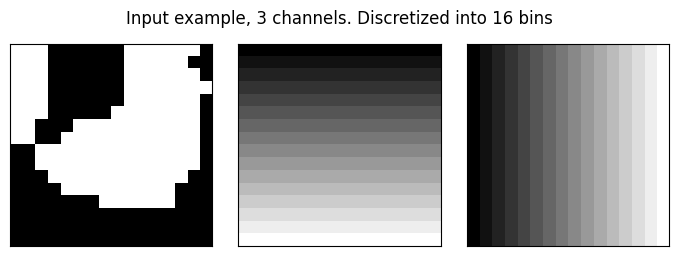

In [ ]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
fig = plt.figure(figsize=(7, 7))

x = input_data

ax = fig.add_subplot(3, 3, 1)
ax.imshow(x.cpu()[:,:,0], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(3, 3, 2)
ax.imshow(x.cpu()[:,:,1], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(3, 3, 3)
ax.imshow(x.cpu()[:,:,2], cmap='gray')

plt.xticks([], [])
plt.yticks([], [])

fig.suptitle('Input example, 3 channels. Discretized into 16 bins', y=0.98)
plt.tight_layout()
fig.show()



In [ ]:
output = torch.Tensor([[[-1.1362],         [-1.1351],         [-1.1344],         [-1.1329],         [-1.1199],         [-1.1155],         [-1.1147],         [-1.1173],         [-1.1278],         [-1.1290],         [-1.1292],         [-1.1295],         [-1.1298],         [-1.1302],         [-1.1320],         [-1.1272]],        [[-1.1351],         [-1.0751],         [-1.0312],         [-0.8657],         [-0.3055],         [-0.0437],         [ 0.0138],         [-0.1326],         [-0.5887],         [-0.6781],         [-0.6927],         [-0.7128],         [-0.7332],         [-0.7529],         [-0.7552],         [-0.7349]],        [[-1.1345],         [-1.0320],         [-0.9526],         [-0.6204],         [ 0.2030],         [ 0.6456],         [ 0.7577],         [ 0.5480],         [-0.0120],         [-0.2408],         [-0.2845],         [-0.3278],         [-0.3702],         [-0.4064],         [-0.3953],         [-0.5233]],        [[-1.1339],         [-0.9982],         [-0.8892],         [-0.4802],         [ 0.5130],         [ 1.0837],         [ 1.2406],         [ 1.0089],         [ 0.3478],         [ 0.1645],         [ 0.0915],         [ 0.0246],         [-0.0419],         [-0.1155],         [-0.2205],         [-0.4622]],        [[-1.1335],         [-0.9698],         [-0.8348],         [-0.6710],         [ 0.7078],         [ 1.3590],         [ 1.5275],         [ 1.3012],         [ 0.6850],         [ 0.5236],         [ 0.4300],         [ 0.3446],         [ 0.2600],         [ 0.1634],         [ 0.0299],         [-0.1558]],        [[-1.1330],         [-0.9436],         [-0.7919],         [-0.3436],         [ 0.9802],         [ 1.5273],         [ 1.6146],         [ 1.4223],         [ 0.9851],         [ 0.8392],         [ 0.7273],         [ 0.6313],         [ 0.5400],         [ 0.4439],         [ 0.3277],         [-0.0664]],        [[-1.1324],         [-0.9071],         [-0.7618],         [ 0.5358],         [ 1.4287],         [ 1.5794],         [ 1.5423],         [ 1.4218],         [ 1.2369],         [ 1.0911],         [ 0.9782],         [ 0.8813],         [ 0.7925],         [ 0.7092],         [ 0.6401],         [ 0.0767]],        [[-1.1318],         [-0.8355],         [-0.2098],         [ 1.4124],         [ 1.5808],         [ 1.6027],         [ 1.5755],         [ 1.4991],         [ 1.3910],         [ 1.2814],         [ 1.1822],         [ 1.0922],         [ 1.0090],         [ 0.9338],         [ 0.8767],         [ 0.2304]],        [[-1.1135],         [ 0.1939],         [ 1.4497],         [ 1.5484],         [ 1.6171],         [ 1.6428],         [ 1.6290],         [ 1.5808],         [ 1.5091],         [ 1.4275],         [ 1.3451],         [ 1.2649],         [ 1.1869],         [ 1.1111],         [ 1.0385],         [ 0.3300]],        [[-1.1054],         [ 0.6862],         [ 1.5128],         [ 1.6021],         [ 1.6637],         [ 1.6909],         [ 1.6862],         [ 1.6548],         [ 1.6039],         [ 1.5414],         [ 1.4736],         [ 1.4035],         [ 1.3311],         [ 1.2536],         [ 1.1631],         [ 0.3129]],        [[-1.1054],         [ 0.5852],         [ 1.5169],         [ 1.6542],         [ 1.7143],         [ 1.7394],         [ 1.7384],         [ 1.7165],         [ 1.6781],         [ 1.6282],         [ 1.5718],         [ 1.5120],         [ 1.4485],         [ 1.3719],         [ 1.1329],         [ 0.2821]],        [[-1.1073],         [ 0.4514],         [ 1.3970],         [ 1.7722],         [ 1.7667],         [ 1.7813],         [ 1.7797],         [ 1.7630],         [ 1.7319],         [ 1.6893],         [ 1.6408],         [ 1.5912],         [ 1.5437],         [ 1.5026],         [ 1.1456],         [ 0.2676]],        [[-1.1089],         [ 0.3613],         [ 1.3053],         [ 1.7965],         [ 1.9404],         [ 1.9508],         [ 1.9097],         [ 1.7923],         [ 1.7662],         [ 1.7238],         [ 1.6784],         [ 1.6369],         [ 1.6014],         [ 1.5481],         [ 1.1144],         [ 0.2314]],        [[-1.1111],         [ 0.2277],         [ 1.0976],         [ 1.6007],         [ 1.8420],         [ 1.9295],         [ 1.9288],         [ 1.8771],         [ 1.8364],         [ 1.8059],         [ 1.7539],         [ 1.6934],         [ 1.6134],         [ 1.4149],         [ 0.9562],         [ 0.1312]],        [[-1.1150],         [-0.0123],         [ 0.6827],         [ 1.0946],         [ 1.3148],         [ 1.4136],         [ 1.4403],         [ 1.4296],         [ 1.4071],         [ 1.3795],         [ 1.3404],         [ 1.2819],         [ 1.1798],         [ 0.9767],         [ 0.5896],         [-0.0789]],        [[-1.1218],         [-0.4277],         [-0.0291],         [ 0.2030],         [ 0.3307],         [ 0.3924],         [ 0.4145],         [ 0.4151],         [ 0.4059],         [ 0.3911],         [ 0.3689],         [ 0.3330],         [ 0.2683],         [ 0.1466],         [-0.0750],         [-0.4626]]])

In [ ]:
# @title
output = torch.Tensor([[[-1.1362],
         [-1.1351],
         [-1.1344],
         [-1.1329],
         [-1.1199],
         [-1.1155],
         [-1.1147],
         [-1.1173],
         [-1.1278],
         [-1.1290],
         [-1.1292],
         [-1.1295],
         [-1.1298],
         [-1.1302],
         [-1.1320],
         [-1.1272]],

        [[-1.1351],
         [-1.0751],
         [-1.0312],
         [-0.8657],
         [-0.3055],
         [-0.0437],
         [ 0.0138],
         [-0.1326],
         [-0.5887],
         [-0.6781],
         [-0.6927],
         [-0.7128],
         [-0.7332],
         [-0.7529],
         [-0.7552],
         [-0.7349]],

        [[-1.1345],
         [-1.0320],
         [-0.9526],
         [-0.6204],
         [ 0.2030],
         [ 0.6456],
         [ 0.7577],
         [ 0.5480],
         [-0.0120],
         [-0.2408],
         [-0.2845],
         [-0.3278],
         [-0.3702],
         [-0.4064],
         [-0.3953],
         [-0.5233]],

        [[-1.1339],
         [-0.9982],
         [-0.8892],
         [-0.4802],
         [ 0.5130],
         [ 1.0837],
         [ 1.2406],
         [ 1.0089],
         [ 0.3478],
         [ 0.1645],
         [ 0.0915],
         [ 0.0246],
         [-0.0419],
         [-0.1155],
         [-0.2205],
         [-0.4622]],

        [[-1.1335],
         [-0.9698],
         [-0.8348],
         [-0.6710],
         [ 0.7078],
         [ 1.3590],
         [ 1.5275],
         [ 1.3012],
         [ 0.6850],
         [ 0.5236],
         [ 0.4300],
         [ 0.3446],
         [ 0.2600],
         [ 0.1634],
         [ 0.0299],
         [-0.1558]],

        [[-1.1330],
         [-0.9436],
         [-0.7919],
         [-0.3436],
         [ 0.9802],
         [ 1.5273],
         [ 1.6146],
         [ 1.4223],
         [ 0.9851],
         [ 0.8392],
         [ 0.7273],
         [ 0.6313],
         [ 0.5400],
         [ 0.4439],
         [ 0.3277],
         [-0.0664]],

        [[-1.1324],
         [-0.9071],
         [-0.7618],
         [ 0.5358],
         [ 1.4287],
         [ 1.5794],
         [ 1.5423],
         [ 1.4218],
         [ 1.2369],
         [ 1.0911],
         [ 0.9782],
         [ 0.8813],
         [ 0.7925],
         [ 0.7092],
         [ 0.6401],
         [ 0.0767]],

        [[-1.1318],
         [-0.8355],
         [-0.2098],
         [ 1.4124],
         [ 1.5808],
         [ 1.6027],
         [ 1.5755],
         [ 1.4991],
         [ 1.3910],
         [ 1.2814],
         [ 1.1822],
         [ 1.0922],
         [ 1.0090],
         [ 0.9338],
         [ 0.8767],
         [ 0.2304]],

        [[-1.1135],
         [ 0.1939],
         [ 1.4497],
         [ 1.5484],
         [ 1.6171],
         [ 1.6428],
         [ 1.6290],
         [ 1.5808],
         [ 1.5091],
         [ 1.4275],
         [ 1.3451],
         [ 1.2649],
         [ 1.1869],
         [ 1.1111],
         [ 1.0385],
         [ 0.3300]],

        [[-1.1054],
         [ 0.6862],
         [ 1.5128],
         [ 1.6021],
         [ 1.6637],
         [ 1.6909],
         [ 1.6862],
         [ 1.6548],
         [ 1.6039],
         [ 1.5414],
         [ 1.4736],
         [ 1.4035],
         [ 1.3311],
         [ 1.2536],
         [ 1.1631],
         [ 0.3129]],

        [[-1.1054],
         [ 0.5852],
         [ 1.5169],
         [ 1.6542],
         [ 1.7143],
         [ 1.7394],
         [ 1.7384],
         [ 1.7165],
         [ 1.6781],
         [ 1.6282],
         [ 1.5718],
         [ 1.5120],
         [ 1.4485],
         [ 1.3719],
         [ 1.1329],
         [ 0.2821]],

        [[-1.1073],
         [ 0.4514],
         [ 1.3970],
         [ 1.7722],
         [ 1.7667],
         [ 1.7813],
         [ 1.7797],
         [ 1.7630],
         [ 1.7319],
         [ 1.6893],
         [ 1.6408],
         [ 1.5912],
         [ 1.5437],
         [ 1.5026],
         [ 1.1456],
         [ 0.2676]],

        [[-1.1089],
         [ 0.3613],
         [ 1.3053],
         [ 1.7965],
         [ 1.9404],
         [ 1.9508],
         [ 1.9097],
         [ 1.7923],
         [ 1.7662],
         [ 1.7238],
         [ 1.6784],
         [ 1.6369],
         [ 1.6014],
         [ 1.5481],
         [ 1.1144],
         [ 0.2314]],

        [[-1.1111],
         [ 0.2277],
         [ 1.0976],
         [ 1.6007],
         [ 1.8420],
         [ 1.9295],
         [ 1.9288],
         [ 1.8771],
         [ 1.8364],
         [ 1.8059],
         [ 1.7539],
         [ 1.6934],
         [ 1.6134],
         [ 1.4149],
         [ 0.9562],
         [ 0.1312]],

        [[-1.1150],
         [-0.0123],
         [ 0.6827],
         [ 1.0946],
         [ 1.3148],
         [ 1.4136],
         [ 1.4403],
         [ 1.4296],
         [ 1.4071],
         [ 1.3795],
         [ 1.3404],
         [ 1.2819],
         [ 1.1798],
         [ 0.9767],
         [ 0.5896],
         [-0.0789]],

        [[-1.1218],
         [-0.4277],
         [-0.0291],
         [ 0.2030],
         [ 0.3307],
         [ 0.3924],
         [ 0.4145],
         [ 0.4151],
         [ 0.4059],
         [ 0.3911],
         [ 0.3689],
         [ 0.3330],
         [ 0.2683],
         [ 0.1466],
         [-0.0750],
         [-0.4626]]])

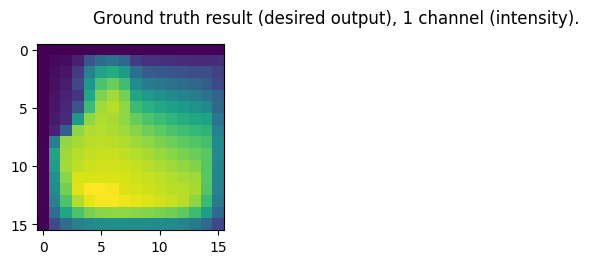

In [ ]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
fig = plt.figure(figsize=(7, 7))

x = output

ax = fig.add_subplot(3, 3, 1)
ax.imshow(x.cpu()[:,:, 0])

fig.suptitle('Ground truth result (desired output), 1 channel (intensity).', y=0.98)
plt.tight_layout()
fig.show()

Now, recall the FNO architecture

![FNO architecture](https://i.imgur.com/muYkubI.png)

## Input function as a tensor

The input function itself, **$a(x)$ on the architecture diagram**,  is 2-dimensional in our workshop (in the sense that the function $a(x)$ is taking arguments in $\mathbb{R}^2$; we will use the notation $a(x, y)$ from now on). As we have seen, it is entering the FNO as a 3rd order tensor, with dimensions Height x Width x 3 (with Height = Width = 16, at least for now). The last order has 3 channels because it is coding function value, i.e. $a(x, y)$, together with $x$-coordinate and $y$-coordinate of the grid.

Batched inputs would be a 4th order tensor.

## Lifting layer as a positional encoding

$P$ is called a lifting layer. It is a regular linear layer, thus it acts on the last order of the entry tensor. It is a matrix multiplication (let us call this matrix $P$ as well) resulting in changing this last dimension to some H - arbitrarily chosen Hidden dimension.

Observe that in each higher-than-1 position in the input tensor, we would be multiplying a vector which is equal
to $(a(x, y), x, y)^T$ by a matrix $P$ sized 3 by H.

This matrix can be considered as equal to 3 vectors $P_v^T, P_x^T, P_y^T$ (all of length H) sitting on top of each other:

$ P=\left[ \array{ P_v^T \\ P_x^T \\ P_y^T} \right ] $

Then

$ (a(x, y), x, y)^T  \left[ \array{ P_v^T \\ P_x^T \\ P_y^T} \right ]  = a(x, y) P_v^T + x P_x^T + y P_y^T $

This results in a rather trivial coding, in which each function value $a(x, y)$ (which is a real number) is scaling a vector $P_v$ of length H and two other such vectors $P_x$ and $P_x$ are scaled by (respectively) $x$ and $y$ and added in something, that may be considered ***positional encoding***.

## Lifting layer as a convolution with H filters

Another way of looking at a transformation
$ (a(x, y), x, y)^T  \rightarrow a(x, y) P_v^T + x P_x^T + y P_y^T $ is
by considering the result coordinates separately. In this way the $i$th coordinate of the results is
$a(x, y) \cdot P_{vi} + x \cdot P_{xi} + y \cdot P_{yi}$ which is equal to
a convolution of the input channels $ (a(x, y), x, y)$ by
a single $1 \times 1$ 3-channel convolution filter $(P_{vi}, P_{xi}, P_{yi})$ (we drop *transpose* as convolution is a dot product). Thus, the complete result (which has H channels) would be a convolution using H such filters.

This way of looking at a lifting layer as convoluting a single point only, enables the user to (hipothetically) improve the trivial coding by using a larger odd-sized kernels (odd-sized kernels, say $(2n+1) \times (2n+1)$ kernels, when accompanied by appropriate padding (symmetric padding with $n$ zeros or, still better, a reflective padding), can produce the result with the same resolution as the input). This would change the coding from the one looking at a single point only to the coding looking still locally, but at a larger local point neighborhoods.

Observe, that if looking point-wise only would be beneficial, an $n \times n$ kernel (for odd $n$) with all zeros except for a central non-zero value, is equivalent to a $1 \times 1$ kernel with that value and our encoder could learn such a kernel.

In summary, after the lifting layer, the tensor entering the Fourier layer, **$v(x)$ on the architecture diagram**, is a 3rd order tensor, with dimensions Height x Width x H (with Height = Width = 16, at least for now) and H being the arbitrarily chosen Hidden dimension.

Batched tensors entering the Fourier layer would be a 4th order tensor.



In [ ]:
Height = Width = 16
H = 8

P = torch.nn.Linear(3, H)

#input_data                 # Height, Width, 3
lifted = P(input_data)      # Height, Width, H

print(lifted)

tensor([[[ 0.8413, -0.1110, -0.1318,  ...,  0.1078, -0.1225,  0.0119],
         [ 0.8372, -0.1239, -0.1038,  ...,  0.1187, -0.1503, -0.0078],
         [ 0.8330, -0.1367, -0.0759,  ...,  0.1295, -0.1780, -0.0275],
         ...,
         [ 0.7874, -0.2777,  0.2314,  ...,  0.2484, -0.4831, -0.2443],
         [ 0.7832, -0.2905,  0.2594,  ...,  0.2592, -0.5109, -0.2641],
         [ 0.2840,  0.1316,  0.3458,  ...,  0.4182, -0.0033, -0.5381]],

        [[ 0.8328, -0.1203, -0.1528,  ...,  0.0961, -0.1371,  0.0323],
         [ 0.8286, -0.1331, -0.1249,  ...,  0.1069, -0.1648,  0.0126],
         [ 0.8245, -0.1459, -0.0970,  ...,  0.1177, -0.1926, -0.0071],
         ...,
         [ 0.7789, -0.2869,  0.2104,  ...,  0.2366, -0.4977, -0.2240],
         [ 0.2797,  0.1352,  0.2968,  ...,  0.3956,  0.0099, -0.4980],
         [ 0.2755,  0.1224,  0.3247,  ...,  0.4064, -0.0178, -0.5178]],

        [[ 0.8243, -0.1295, -0.1739,  ...,  0.0843, -0.1517,  0.0526],
         [ 0.8201, -0.1423, -0.1460,  ...,  0

Now let us build the equivalent convolution from $P$

In [ ]:
print(P.weight.size())


torch.Size([8, 3])


In [ ]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = H, kernel_size = 1)
print(conv.weight.size())


torch.Size([8, 3, 1, 1])


In [ ]:
conv.weight.data = P.weight.unsqueeze(-1).unsqueeze(-1).data
conv.bias.data = P.bias.data

In [ ]:
#input_data                                                  # Height, Width, 3

                # making channels first in input, as required by convolutions
permuted_input = torch.permute(input_data, (-1, -3, -2))     # 3, Height, Width

lifted_conv = conv(permuted_input)                           # H, Height, Width

                # and making channels last in the output
lifted_conv = torch.permute(lifted_conv, (-2, -1, -3))       # Height, Width, H

print(lifted_conv == lifted)   #All equal?

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [

OK, the equivalence of the linear lifting layer and a 1x1 kernel convolution has been proven by example.

### Task #1: Why count from the end?

### Answer (do not peak)

To make the code compatible with the batched version. The batches are the tensor orders that tend to be first. If we don't know if they are present or not - it is convenient to count from the end, that way we don't care about batches.

Now, recall the FNO architecture

![FNO architecture](https://i.imgur.com/muYkubI.png)

## A single Fourier layer

Before entering Fourier layer we need to move channels as the third (from the end) order in our tensor. The resulting tensor would be an order three tensor, with dimensions H, Width and Height.

In this sense, using the convolutional lifting (which also likes to have channels first) is an even more natural choice.


### Discrete Fourier Transform (DFT) Mathematically

The Discrete Fourier Transform (DFT) transforms an $N$-element sequence $(x_0, x_2, \ldots, x_{N-1})$ is defined as follows:

$X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i 2 \pi \cdot \frac{k}{N} \cdot n}$,

you'll notice that immediately we get
$X_0 = \sum_{n=0}^{N-1} x_n \cdot e^{-i 2 \pi \cdot \frac{0}{N} \cdot n} = \sum_{n=0}^{N-1} x_n$.


In [ ]:
torch.fft.fft(torch.Tensor([1,2,3,4]))

tensor([10.+0.j, -2.+2.j, -2.+0.j, -2.-2.j])

Let's quickly calculate $X_1$, in which $e^\frac{-i \pi}{2}$ (going $90^{\circ}$ clockwise in a unit circle) is raised to powers 0, 1, 2 and 3 (read: it is repeated this amount of times), so the real part would be equal to $1 - 3 = -2$, and the imaginary part would be equal to $-2+4 = 2$. All seems to check.

### Frequencies

Those values $\frac{k}{N}$ are called *frequencies*.

Due to the nature of going around in circles, the frequency $\frac{k}{N} > 0$ is the same as $\frac{k-N}{N} <0$ (going a quarter of the unit circle clockwise is the same as going three quarters counter-clockwise). In the above examples, we have been working with frequencies $0, \frac{1}{4}, \frac{2}{4}$ (same as $\frac{-2}{4}$) and $\frac{3}{4}$ (same as $\frac{-1}{4}$).

So, $X_k$, the value for the frequency $\frac{k}{N}$, is the same as $X_{k-N}$, the value for the frequency $\frac{k-N}{N}$. Using induction, $X_k = X_m$ (with $m$ negative or positive) provided that $m$ is equal to $k$ modulo $N$.

### Real signal

The DFT of a real signal has the property, that its value for the positive frequency $\frac{k}{N}$, $X_k$ is conjugate to the corresponding value for the negative frequency $\frac{-k}{N}$, $X_{-k}$. You'll notice again that in our example with $N=4$, $X_2$ is real (conjugate of itself) and $X_3$ is a conjugate of $X_{-3}=X_1$.

### Inverse DFT (IDFT)

The inverse DFT (IDFT) is given by a formula very similar to DFT:

$x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k \cdot e^{i 2 \pi \cdot \frac{n}{N} \cdot k}$,

note the presence of $\frac{1}{N}$ and the changed direction in which we traverse the unit circle.

**Note**: This is just one of a few existing alternative forms, other possibilities include $\frac{1}{\sqrt N}$ in DFT and IDFT, both. Pytorch uses the forms listed above as default, but supports other forms as well.


## Fast Fourier Transform

Fast Fourier Transform (FFT) is an algorithm. It is an efficient algorithm for computing Discrete Fourier Transform. There exists also a corresponding version of FFT for the inverse transform, IFFT.

**The naive (straightforward) algorithm to compute DFT has complexity $\mathcal{O}(N^2)$. In contrast, FFT exploits regularities in DFT and has complexity $\mathcal{O}(N\log{N})$**.

### Convolution Theorem

Performing circular convolution of two sequences is equivalent to performing the pointwise multiplication in the Fourier domain, informally:

$x \star y = IDFT (DFT(x) \cdot DFT(y) )$

**Performing circular convolution in real domain has complexity $\mathcal{O}(N^2)$. In contrast, performing FFT, pointwise multiplication in Fourier domain and then IFFT has complexity $\mathcal{O}(N\log{N})$**.

### 2D Discrete Fourier Transform

2D DFT of the points organized in a rectangular grid with $R$ rows and $C$ columns:

$X_{k_R,k_C} =  \sum_{r=0}^{R-1} \sum_{c=0}^{C-1} x_{r,c} \cdot e^{-i \left( \frac{2 \pi k_R}{R}r + \frac{2 \pi k_C}{C}c \right)} $

can also be considered as a sequence of 1D DFTs, first by obtaining DFT for each row and then for resulting transformed columns:

$X_{k_R,k_C} = \sum_{r=0}^{R-1}  \left (\sum_{c=0}^{C-1} x_{r,c} \cdot e^{-i \frac{2 \pi k_C}{C}c } \right ) \cdot e^{-i \frac{2 \pi k_R}{R}r } $

or vice-versa:

$X_{k_R,k_C} =\sum_{c=0}^{C-1}  \left ( \sum_{r=0}^{R-1} x_{r,c} \cdot e^{-i \frac{2 \pi k_R}{R}r } \right ) \cdot e^{-i \frac{2 \pi k_C}{C}c } $

**Obviously, for the real 2D signal, the DFT observes corresponding regularities that we listed for the 1D real signal**.

**Also, there is a corresponding inverse DFT, IDFT**.


## Fast Fourier Transform algorithm (with autograd :) in PyTorch

The implementation of FFT in Pytorch is given by `fft()` function. It supports automatic gradient.

### `fftfreq` function

By convention, `fft()` returns positive frequency terms first, followed by the negative frequencies in reverse order. We can list those frequencies with `fftfreq` function:

In [ ]:
torch.fft.fftfreq(4)

tensor([ 0.0000,  0.2500, -0.5000, -0.2500])


### 2D FFT in PyTorch

For a 2D FFT we need `fft2()` or `rfft2()` functions. **The latter exploits the regularities for the real signal.** Below is a FFT of a 4 by 4 example tensor, in two versions:

In [ ]:
torch.fft.fft2(torch.Tensor([[1,2,3,4],[6,2,3,4], [1,8,3,4],[1,12,3,4]]))

tensor([[ 61.+0.j,  -3.-8.j, -19.+0.j,  -3.+8.j],
        [ -6.+5.j,  10.+1.j,   6.-15.j, -10.-11.j],
        [ -9.+0.j,  -5.+4.j,  -1.+0.j,  -5.-4.j],
        [ -6.-5.j, -10.+11.j,   6.+15.j,  10.-1.j]])

In [ ]:
torch.fft.rfft2(torch.Tensor([[1,2,3,4],[6,2,3,4], [1,8,3,4],[1,12,3,4]]))

tensor([[ 61.+0.j,  -3.-8.j, -19.+0.j],
        [ -6.+5.j,  10.+1.j,   6.-15.j],
        [ -9.+0.j,  -5.+4.j,  -1.+0.j],
        [ -6.-5.j, -10.+11.j,   6.+15.j]])

**Very important:** This matrix indices are in fact frequencies as listed by `fftfreq` function. Recall that `fftfreq()` returns positive frequency terms first, followed by the negative frequencies in reverse order. We shall yet use this, this is very important. [More info in this link](https://runebook.dev/en/docs/pytorch/fft).

In [ ]:
torch.fft.fftfreq(4)

tensor([ 0.0000,  0.2500, -0.5000, -0.2500])

**From the [help page on `rfft2`](https://pytorch.org/docs/stable/generated/torch.fft.rfft2.html)**:

`rfft2` computes the 2-dimensional discrete Fourier transform of real input. Equivalent to rfftn() but FFTs only the last two dimensions by default.

The FFT of a real signal is Hermitian-symmetric, **X[i, j] = conj(X[-i, -j])**, so the full fft2() output contains redundant information. rfft2() instead omits the negative frequencies in the last dimension.

Let's see:
```
-3+8j   = X[0, 3] = X[0.0, -0.25]   = conj(X[0.0, 0.25])   = conj(X[0, 1]) = conj(-3-8j)
-10-11j = X[1, 3] = X[0.25, -0.25]  = conj(X[-0.25, 0.25]) = conj(X[3, 1]) = conj(-10+11j)
-5-4j   = X[2, 3] = X[-0.5, -0.25]  = conj(X[0.5, 0.25])   = conj(X[2, 1]) = conj(-5+4j)
-10-1j  = X[3, 3] = X[-0.25, -0.25] = conj(X[0.25, 0.25])  = conj(X[1, 1]) = conj(-10+1j)
```



Let's see the frequencies list for a larger sample of points:

In [ ]:
torch.fft.fftfreq(16)

tensor([ 0.0000,  0.0625,  0.1250,  0.1875,  0.2500,  0.3125,  0.3750,  0.4375,
        -0.5000, -0.4375, -0.3750, -0.3125, -0.2500, -0.1875, -0.1250, -0.0625])

Observe that the information from the help page (**marked as important**) is confirmed here: the highest frequencies are in a middle of the list, while low frequencies, both positive and negative, are kept in the beginning and end of this list. However, this list is not symmetric, as it starts with 0.0 (a constant, no frequency) and the *remaining* part is symmetric.

### The effect of removing the highest frequencies

### Task #2: Removing highest frequencies from a rectangle

Say we have a rectangle

Text(0.5, 1.0, 'Rectangle')

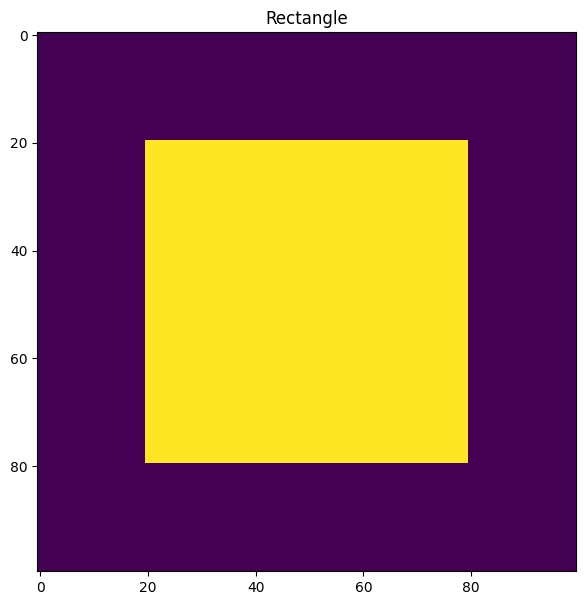

In [ ]:
rectangle = torch.zeros((100, 100))
rectangle[20:80, 20:80] = 1.0

fig = plt.figure(figsize=(7, 7))


x = rectangle
ax = fig.add_subplot(1, 1, 1)
ax.imshow(x.cpu()[:,:])
ax.set_title('Rectangle')

What would be the effect of moving it into Fourier domain, removing the highest frequencies and moving it back to the real domain?

### Answer (do not peak)



Inside the fourier layer only the lowest frequencies will be preserved (multiplied by some positive weights). The highest frequencies will be zeroed-out. To help understand the overall effect of that transformation, see below the code transforming a rectangle into the Fourier domain, zeroing-out the highest frequencies and then going back to the real domain.



In [ ]:
def into_fourier_domain_and_back(rectangle, low_frequencies_count, plot_before):
    rectangle_fourier = torch.fft.fft2(rectangle)

    # removing the highest frequency component
    rectangle_fourier_low_frequencies = torch.complex(torch.zeros(rectangle_fourier.size()), torch.zeros(rectangle_fourier.size()))

    if low_frequencies_count == 0:
      zero_or_positive_frequencies_count = negative_frequencies_count = 0
    else:
      zero_frequency_count = 1
      positive_frequencies_count = (low_frequencies_count - 1)//2
      zero_or_positive_frequencies_count = positive_frequencies_count + zero_frequency_count
      negative_frequencies_count = low_frequencies_count - zero_or_positive_frequencies_count
    for r in range(100):
      for c in range(100):
        if (r < zero_or_positive_frequencies_count or r >= 100 - negative_frequencies_count) and \
           (c < zero_or_positive_frequencies_count or c >= 100 - negative_frequencies_count):
           rectangle_fourier_low_frequencies[r, c] = rectangle_fourier[r, c]


    rectangle_back = torch.real(torch.fft.ifft2(rectangle_fourier_low_frequencies))


    # adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
    fig = plt.figure(figsize=(7, 7))

    if plot_before:
      x = rectangle
      ax = fig.add_subplot(2, 3, 1)
      ax.imshow(x.cpu()[:,:])
      ax.set_title('Before')

      x = torch.real(rectangle_fourier)
      ax = fig.add_subplot(2, 3, 2)
      ax.imshow(x.cpu()[:,:])
      ax.set_title('DFT real part')

      x = torch.imag(rectangle_fourier)
      ax = fig.add_subplot(2, 3, 3)
      ax.imshow(x.cpu()[:,:])
      ax.set_title('DFT imaginary part')


    x = rectangle_back
    ax = fig.add_subplot(1 + plot_before, 3, 1 + 3*plot_before)
    ax.imshow(x.cpu()[:,:])
    ax.set_title('After, mean=%.2f'%torch.mean(x.cpu()).item())

    x = torch.real(rectangle_fourier_low_frequencies)
    ax = fig.add_subplot(1 + plot_before, 3, 2 + 3*plot_before)
    ax.imshow(x.cpu()[:,:])
    ax.set_title('DFT %d lowest frequencies real part'%low_frequencies_count)


    x = torch.imag(rectangle_fourier_low_frequencies)
    ax = fig.add_subplot(1 + plot_before, 3, 3 + 3*plot_before)
    ax.imshow(x.cpu()[:,:])
    ax.set_title('DFT imaginary part')

    if plot_before:
      fig.suptitle('Rectangle BEFORE and AFTER the highest frequency component is removed', y=0.98)
    plt.tight_layout()
    fig.show()

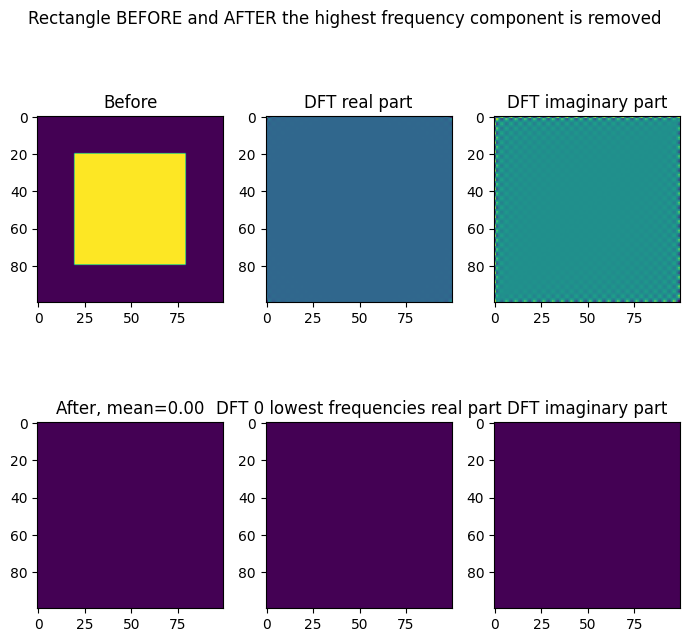

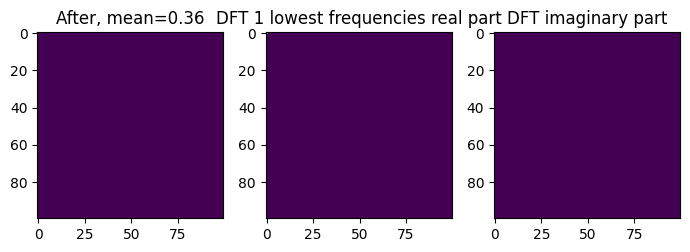

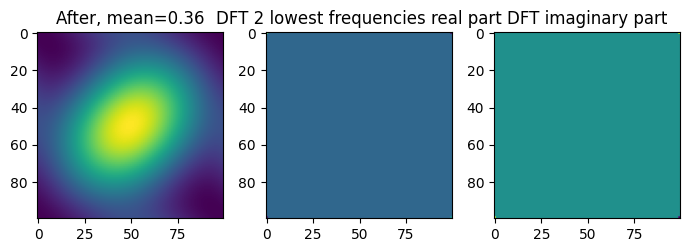

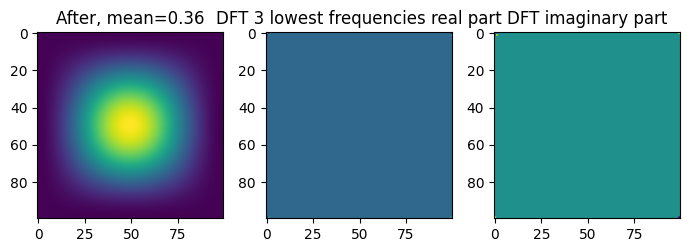

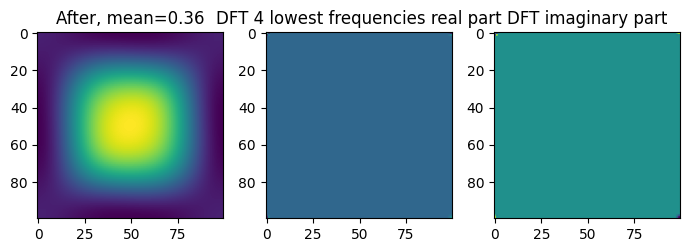

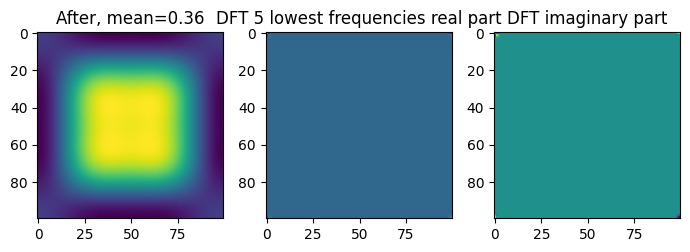

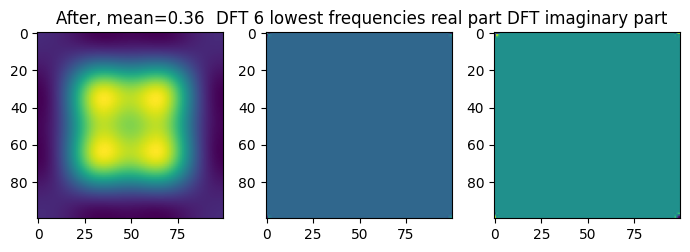

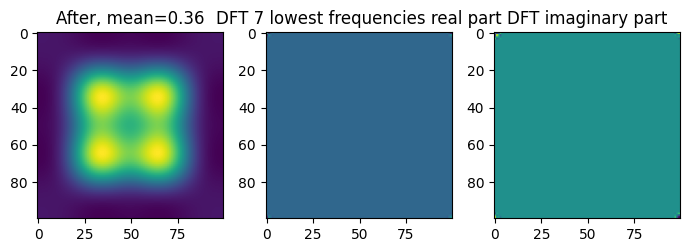

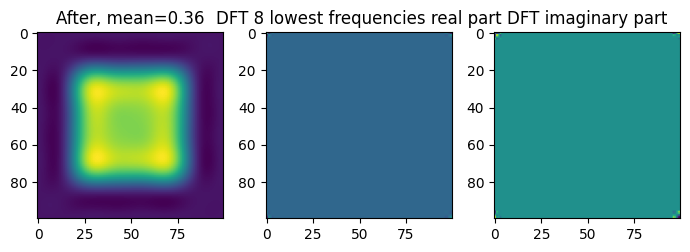

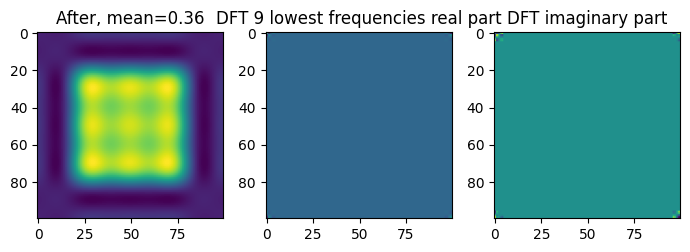

In [ ]:
for low_frequencies_count in range(10):
    into_fourier_domain_and_back(rectangle, low_frequencies_count, True if low_frequencies_count == 0 else False)

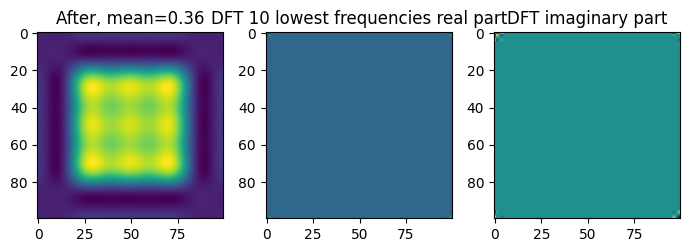

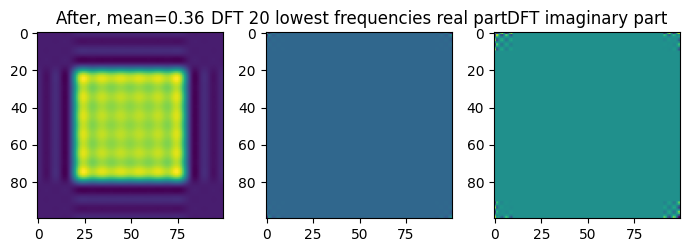

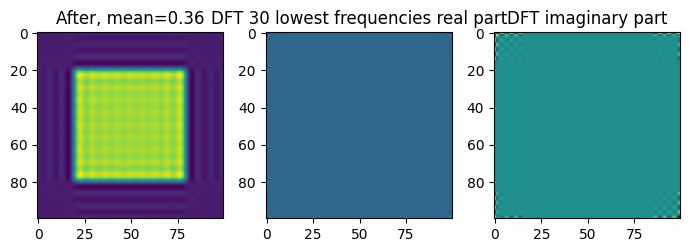

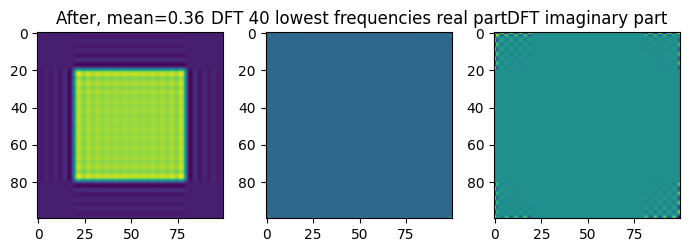

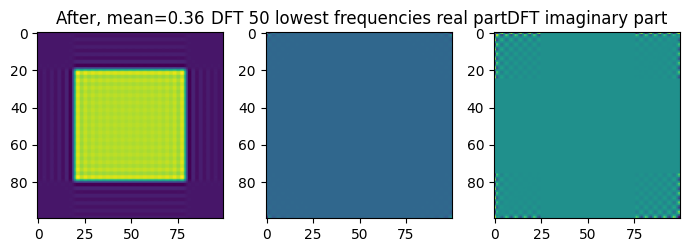

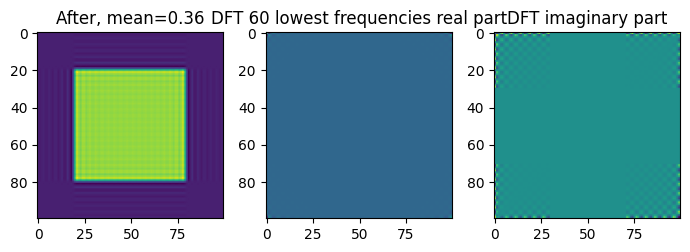

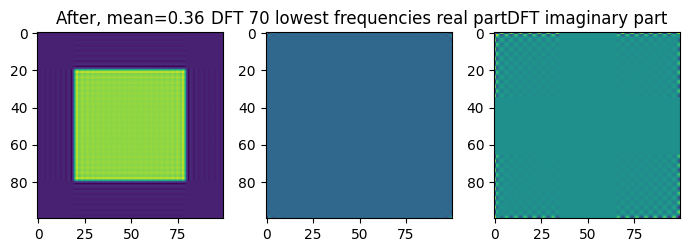

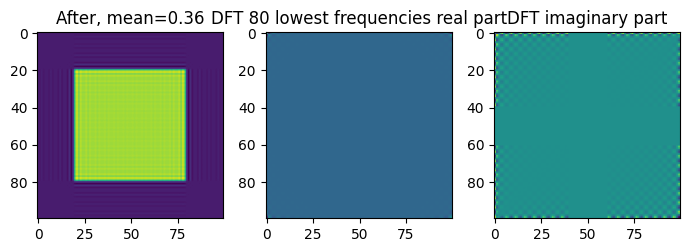

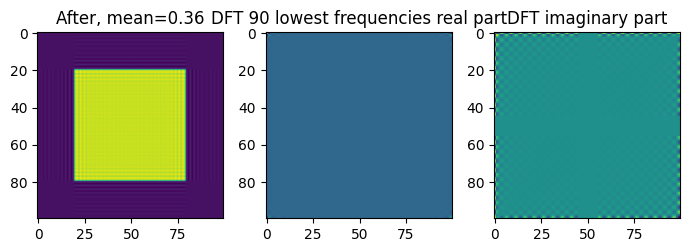

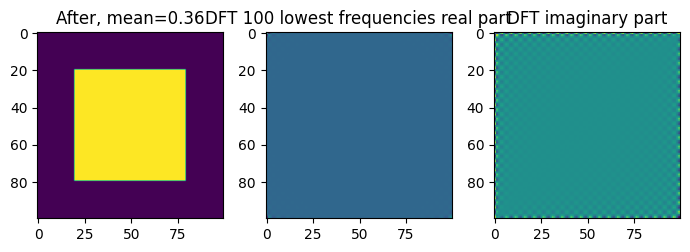

In [ ]:
for low_frequencies_count in range(10,110, 10):
    into_fourier_domain_and_back(rectangle, low_frequencies_count, False)

## Fourier layer definition by Zongyi Li

We'll use the code written by **Zongyi Li, the first author of the FNO paper**

In [ ]:
"""
code adapted from from: https://github.com/khassibi/fourier-neural-operator/blob/main/fourier_2d.py

@original code author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).

changes: removed batching for now
         added comments

"""

################################################################
# fourier layer
################################################################
class SpectralConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = torch.nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (in_channel, x,y ), (in_channel, out_channel, x,y) -> (out_channel, x,y)
        return torch.einsum("ixy,ioxy->oxy", input, weights)
        # einstein summation convention is the most general way to code transformation on two tensors
        # the x and y coordinates get matched
        # for each o coordinate separately
        # the sum is calculated over the i coordinates

    def forward(self, x):
        #Compute Fourier coeffcients up to factor of e^(- something constant)

        x_ft = torch.fft.rfft2(x)

        # zero out the output tensor, so that the high frequencies will remain zero
        out_ft = torch.zeros(self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)

        # Multiply relevant Fourier modes

        # first compute the product of weights with the lowest *positive-or-zero* frequencies
        # including the constant frequency and `modes`-1 higher frequencies
        out_ft[:, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :self.modes1, :self.modes2], self.weights1)

        # then, compute the product of weights with the lowest *negative* frequencies
        # this makes `modes` negative frequencies
        out_ft[:, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, -self.modes1:, :self.modes2], self.weights2)

        ########## !!!! print !!!!!!  #############
        print("A peek onto the output tensor (1st channel) still in the Fourier domain:")
        print(out_ft[1])     # printing out the 1st channel of the output tensor, still in Fourier space

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [ ]:
Modes = 3

fourier_layer = SpectralConv2d(H, H, Modes, Modes)
                                              # defines a fourier layer with H in channels
                                              #                              H out channels
                                              #                              3 lowest positive frequencies are retained in the first dimension
                                              #                              (including the constant frequency and 2 other)
                                              #                              3 lowest negative frequencies are retained in the first dimension
                                              #                              3 lowest positive frequencies are retained in the second dimension
                                              #                              (including the constant frequency and 2 other,
                                              #                              the remaining 3 lowest negative frequencies are redundant)

# v                                                       # Height, Width, H
lifted_channels_first = torch.permute(lifted, (2, 0, 1))  # H, Height, Width

fourier_result = fourier_layer(lifted_channels_first)     # H, Height, Width

A peek onto the output tensor (1st channel) still in the Fourier domain:
tensor([[ 1.1199+0.7528j, -0.0239+0.0235j, -0.1128-0.0685j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 0.6854-0.3325j,  0.3218+0.2804j,  0.0420+0.0148j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 0.1583-0.0753j,  0.0085+0.0121j,  0.0456-0.0096j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j],
        [ 0.0000+0.000

In [ ]:
print("A peek onto the output tensor (1st channel) in the REAL domain:")
print(fourier_result[0])     # printing out the 1st channel of the output tensor

A peek onto the output tensor (1st channel) in the REAL domain:
tensor([[ 3.5923e-04, -1.1159e-03, -3.1040e-03, -4.9074e-03, -5.7851e-03,
         -5.3382e-03, -3.7266e-03, -1.5906e-03,  2.7789e-04,  1.3294e-03,
          1.4958e-03,  1.1464e-03,  8.0125e-04,  7.7791e-04,  9.8813e-04,
          1.0050e-03],
        [ 1.5052e-03,  5.0144e-04, -8.9842e-04, -2.3551e-03, -3.3020e-03,
         -3.2334e-03, -1.9935e-03,  1.0268e-04,  2.3913e-03,  4.1623e-03,
          4.9799e-03,  4.8458e-03,  4.1252e-03,  3.2893e-03,  2.6317e-03,
          2.1263e-03],
        [ 2.4283e-03,  1.9474e-03,  9.0481e-04, -4.2219e-04, -1.3698e-03,
         -1.2591e-03,  1.8730e-04,  2.6306e-03,  5.2372e-03,  7.0754e-03,
          7.5712e-03,  6.7677e-03,  5.2491e-03,  3.7810e-03,  2.8813e-03,
          2.5685e-03],
        [ 2.7347e-03,  2.6303e-03,  1.5018e-03, -5.7056e-05, -9.6341e-04,
         -3.0497e-04,  2.0673e-03,  5.3705e-03,  8.2562e-03,  9.5106e-03,
          8.6936e-03,  6.3512e-03,  3.6858e-03,  1.87

**Important:** you'll notice, that the output tensor in Fourier domain was not the image of a real tensor. The 0th coordinate was not real, for starters.

However, when `irfft` was computed, it dropped any remaining imaginary part from the resulting tensor.

### Alternative way to calculate this result (1st channel only)

A pointwise multiplication in Fourier domain is equivalent to circular convolution in the real domain. Let's try to perform the same operation as earlier, but in the real domain.

**In order to that:**

- we'll construct the `weights` tensor in Fourier domain, and
- we'll inverse transform it to the real domain to get the `weights_inverse_transformed` tensor,
- then, we'll perform a circular convolution to see the equivalence.



#### First, initiate a H by Height by Width **complex** float Tensor with zeros

In [ ]:
weights = torch.zeros((H, Height, Width), dtype = torch.cfloat)

#### Then, take the H by 6 by 3 weight matrix out of the Fourier layer...

... and populate with it the `weights` tensor

In [ ]:
# weights1, as you recall, relate to the lowest *positive* frequencies
weights[:, :Modes, :Modes] = fourier_layer.weights1[:, 0 ]

# weights2, as you recall, relate to the lowest *negative* frequencies
weights[:, -Modes:, :Modes] = fourier_layer.weights2[:, 0]

#### Then, add the conjugate-symmetric part

In [ ]:
for r in range(Height):
  for c in range(Width // 2 + 1, Width):
    weights[:, r, c] = torch.conj(weights[:, (- r) % Height, (- c) % Width])

#### Now, take `weights` into the real domain

In [ ]:
weights_inverse_transformed = torch.fft.ifft2(weights)

print(weights_inverse_transformed)

tensor([[[ 9.9586e-04+1.8804e-04j,  4.0382e-04+1.8804e-04j,
          -2.7660e-04+1.8804e-04j,  ...,
           6.6197e-04+1.8804e-04j,  1.0992e-03+1.8804e-04j,
           1.2530e-03+1.8804e-04j],
         [ 8.7921e-04+1.2353e-04j,  4.0769e-04+1.2353e-04j,
          -1.5197e-04+1.2353e-04j,  ...,
           5.2065e-04+1.2353e-04j,  9.0616e-04+1.2353e-04j,
           1.0636e-03+1.2353e-04j],
         [ 3.7252e-04+2.9163e-05j,  1.1791e-04+2.9163e-05j,
          -1.3855e-04+2.9163e-05j,  ...,
           2.9352e-04+2.9163e-05j,  4.7315e-04+2.9163e-05j,
           5.0991e-04+2.9163e-05j],
         ...,
         [-1.1197e-04+3.4417e-05j, -1.9009e-04+3.4417e-05j,
          -1.7107e-04+3.4417e-05j,  ...,
           9.6577e-05+3.4417e-05j,  9.8089e-05+3.4417e-05j,
           1.0007e-05+3.4417e-05j],
         [ 2.2909e-04+1.1475e-04j, -7.1285e-05+1.1475e-04j,
          -3.1588e-04+1.1475e-04j,  ...,
           3.4974e-04+1.1475e-04j,  4.8784e-04+1.1475e-04j,
           4.4716e-04+1.1475e-04j],
 

Not so real, hm? That's correct, the weights in Fourier domain were not designed to be the image of a real tensor. However, recall, that the `irfft` computed on the output tensor in a fourier domain (which was not an image of a real tensor, either) simply dropped the imaginary part. Let's proceed the same way, dropping the imaginary part from `weights_inverse_transformed`.



In [ ]:
weights_inverse_transformed = torch.real(weights_inverse_transformed)

print(weights_inverse_transformed)

tensor([[[ 9.9586e-04,  4.0382e-04, -2.7660e-04,  ...,  6.6197e-04,
           1.0992e-03,  1.2530e-03],
         [ 8.7921e-04,  4.0769e-04, -1.5197e-04,  ...,  5.2065e-04,
           9.0616e-04,  1.0636e-03],
         [ 3.7252e-04,  1.1791e-04, -1.3855e-04,  ...,  2.9352e-04,
           4.7315e-04,  5.0991e-04],
         ...,
         [-1.1197e-04, -1.9009e-04, -1.7107e-04,  ...,  9.6577e-05,
           9.8089e-05,  1.0007e-05],
         [ 2.2909e-04, -7.1285e-05, -3.1588e-04,  ...,  3.4974e-04,
           4.8784e-04,  4.4716e-04],
         [ 6.9400e-04,  1.7283e-04, -3.6829e-04,  ...,  5.9445e-04,
           9.1606e-04,  9.7398e-04]],

        [[ 7.4411e-04,  2.7067e-04, -1.8472e-04,  ...,  8.2862e-04,
           1.0592e-03,  1.0422e-03],
         [ 7.7596e-04,  4.7494e-04,  8.0432e-05,  ...,  4.3060e-04,
           7.1080e-04,  8.5914e-04],
         [ 2.8748e-04,  2.8014e-04,  1.9025e-04,  ..., -1.9720e-05,
           8.7834e-05,  2.1007e-04],
         ...,
         [-1.9240e-04, -6

**Note that the `weights` in a Fourier domain was mostly zero with the exception of the most relevant modes, only. Now (when inverse-transformed) it is a large non-zero matrix**

#### Finally, perform the circular convolution

In [ ]:
def circular_reverse_and_shift(tensor, row_shift, col_shift):
  output_tensor = torch.zeros(tensor.size())
  for r in range(tensor.size(1)):
    for c in range(tensor.size(2)):
      output_tensor[:, r, c] = tensor[:, (-r + row_shift) % tensor.size(1), (-c + col_shift) % tensor.size(2)]
  return output_tensor

alternative_result = torch.zeros(fourier_result[0].size())

for row_shift in range(Height ):
   for col_shift in range(Width):
     alternative_result[row_shift, col_shift] = torch.sum(
        circular_reverse_and_shift(lifted_channels_first, row_shift, col_shift)
        * weights_inverse_transformed)

print(torch.isclose(torch.real(alternative_result), fourier_result[0]))

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,

**Note that not only the inverse weights matrix is *not* sparse, but note also how much more computationally demanding it has been to perform the circular convolution, compared to a pointwise product in Fourier domain.**

However, our excersize led to computing the circular convolution matrix, let's at least visualize it


<Figure size 700x700 with 0 Axes>

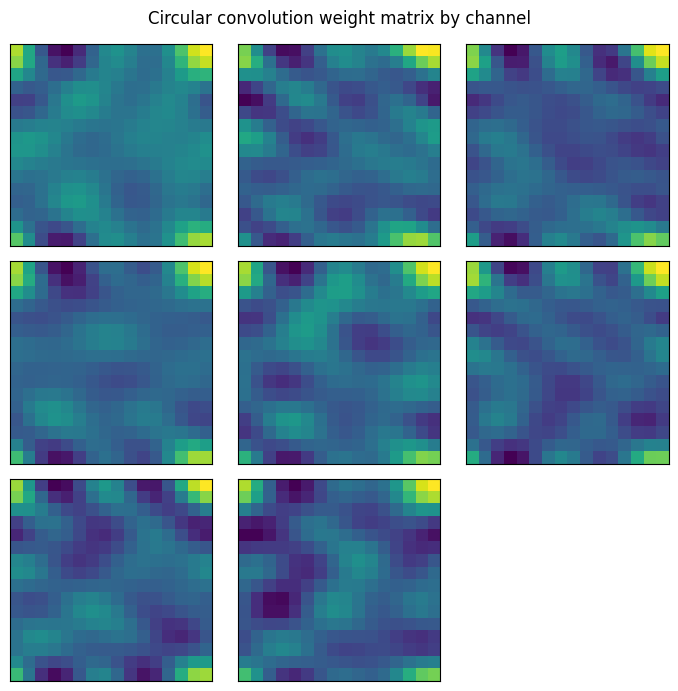

In [ ]:
# adapted from https://github.com/neuraloperator/neuraloperator/blob/main/examples/plot_FNO_darcy.py
fig = plt.figure(figsize=(7, 7))

weight_channel = weights_inverse_transformed.detach()


fig = plt.figure(figsize=(7, 7))
for r in range(3):
  for c in range(3 if r<=1 else 2):
    x = weight_channel[r * 3 + c]

    ax = fig.add_subplot(3, 3, r*3 + c + 1)
    ax.imshow(x.cpu()[:,:])
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Circular convolution weight matrix by channel', y=0.98)
plt.tight_layout()
fig.show()

# Questions ?